# Importing required Libraries

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import qqplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [220]:
data=pd.read_csv('Walmart.csv')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [221]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         143 non-null    int64  
 1   Date          143 non-null    object 
 2   Weekly_Sales  143 non-null    float64
 3   Holiday_Flag  143 non-null    int64  
 4   Temperature   143 non-null    float64
 5   Fuel_Price    143 non-null    float64
 6   CPI           143 non-null    float64
 7   Unemployment  143 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 9.1+ KB


In [222]:
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

# EDA

In [223]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,143.0,1.430000e+02,143.000000,143.000000,143.000000,143.000000,143.000000
mean,1.0,1.555264e+06,0.069930,68.306783,3.219699,215.996892,7.610420
std,0.0,1.559808e+05,0.255926,14.250486,0.427313,4.350890,0.383749
min,1.0,1.316899e+06,0.000000,35.400000,2.514000,210.337426,6.573000
25%,1.0,1.458105e+06,0.000000,58.265000,2.764500,211.549277,7.348000
50%,1.0,1.534850e+06,0.000000,69.640000,3.290000,215.459905,7.787000
75%,1.0,1.614892e+06,0.000000,80.485000,3.594000,220.531330,7.838000
max,1.0,2.387950e+06,1.000000,91.650000,3.907000,223.444251,8.106000


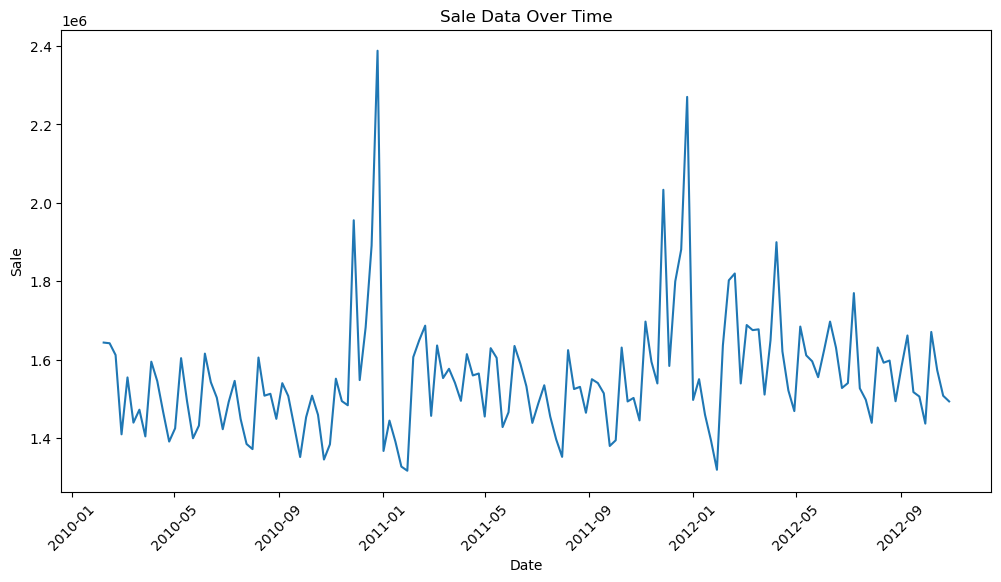

In [224]:
plt.figure(figsize=(12, 6))
data.set_index('Date',inplace=True)
data_resampled = data.resample('W')['Weekly_Sales'].mean()

# Plotting the data
plt.plot(data_resampled.index, data_resampled.values)  # Plotting date vs. sales

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sale')
plt.title('Sale Data Over Time')
plt.xticks(rotation=45)
# Display the plot
plt.show()


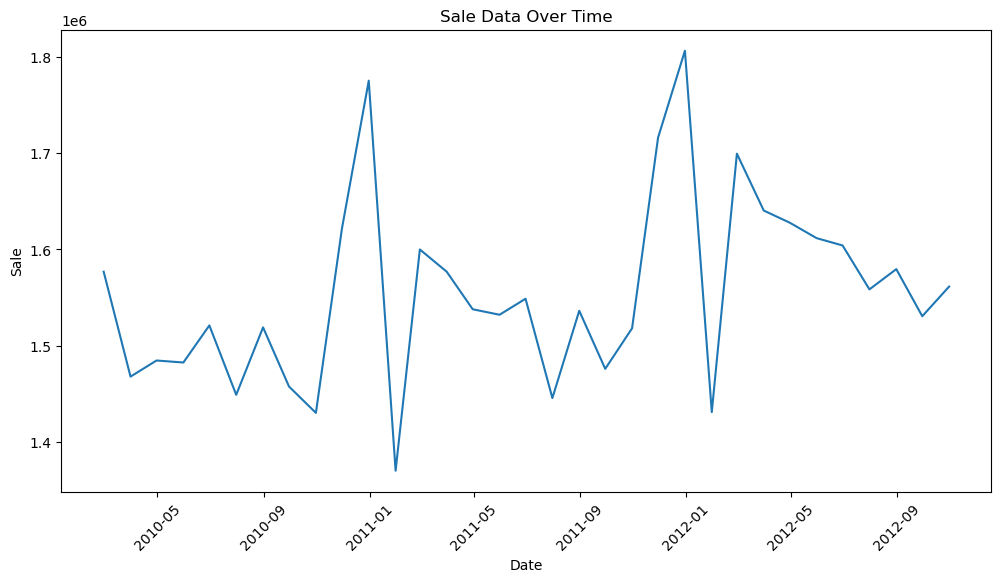

In [225]:
#resampling to monthly

plt.figure(figsize=(12, 6))
data_resampled = data.resample('M')['Weekly_Sales'].mean()

# Plotting the data
plt.plot(data_resampled.index, data_resampled.values)  # Plotting date vs. sales

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sale')
plt.title('Sale Data Over Time')
plt.xticks(rotation=45)
# Display the plot
plt.show()


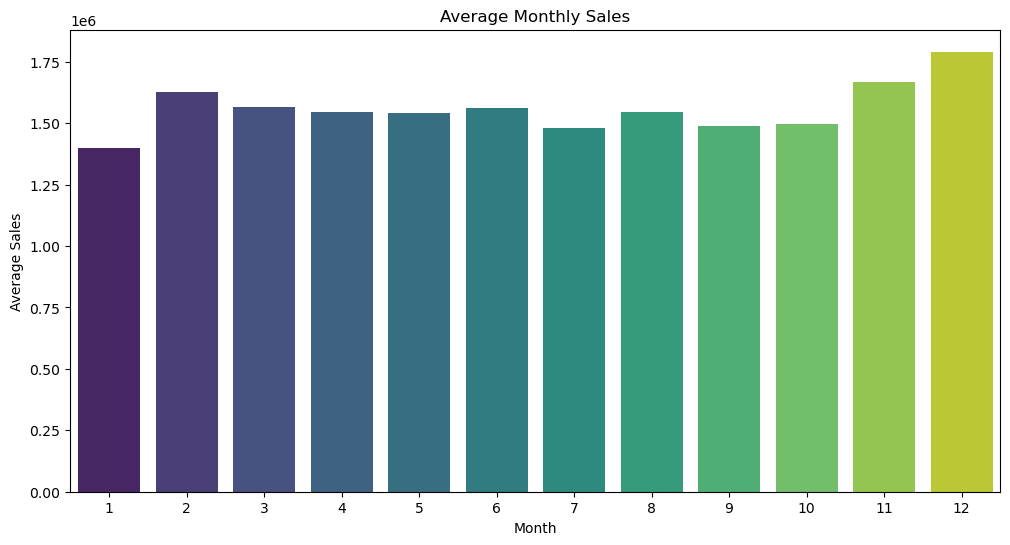

In [226]:
# Adding a 'Month' column for seasonal analysis
data['Month'] = data.index.month

# Plotting Seasonal Patterns
monthly_sales = data.groupby('Month')['Weekly_Sales'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_sales.index, y=monthly_sales.values, palette='viridis')
plt.title('Average Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.show()

In [227]:
data=data.reset_index()
data['Date'] = pd.to_datetime(data['Date'],dayfirst=True)
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Week'] = data['Date'].dt.isocalendar().week
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          143 non-null    datetime64[ns]
 1   Store         143 non-null    int64         
 2   Weekly_Sales  143 non-null    float64       
 3   Holiday_Flag  143 non-null    int64         
 4   Temperature   143 non-null    float64       
 5   Fuel_Price    143 non-null    float64       
 6   CPI           143 non-null    float64       
 7   Unemployment  143 non-null    float64       
 8   Month         143 non-null    int64         
 9   Year          143 non-null    int64         
 10  Day           143 non-null    int64         
 11  Week          143 non-null    UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(5), int64(5)
memory usage: 13.1 KB


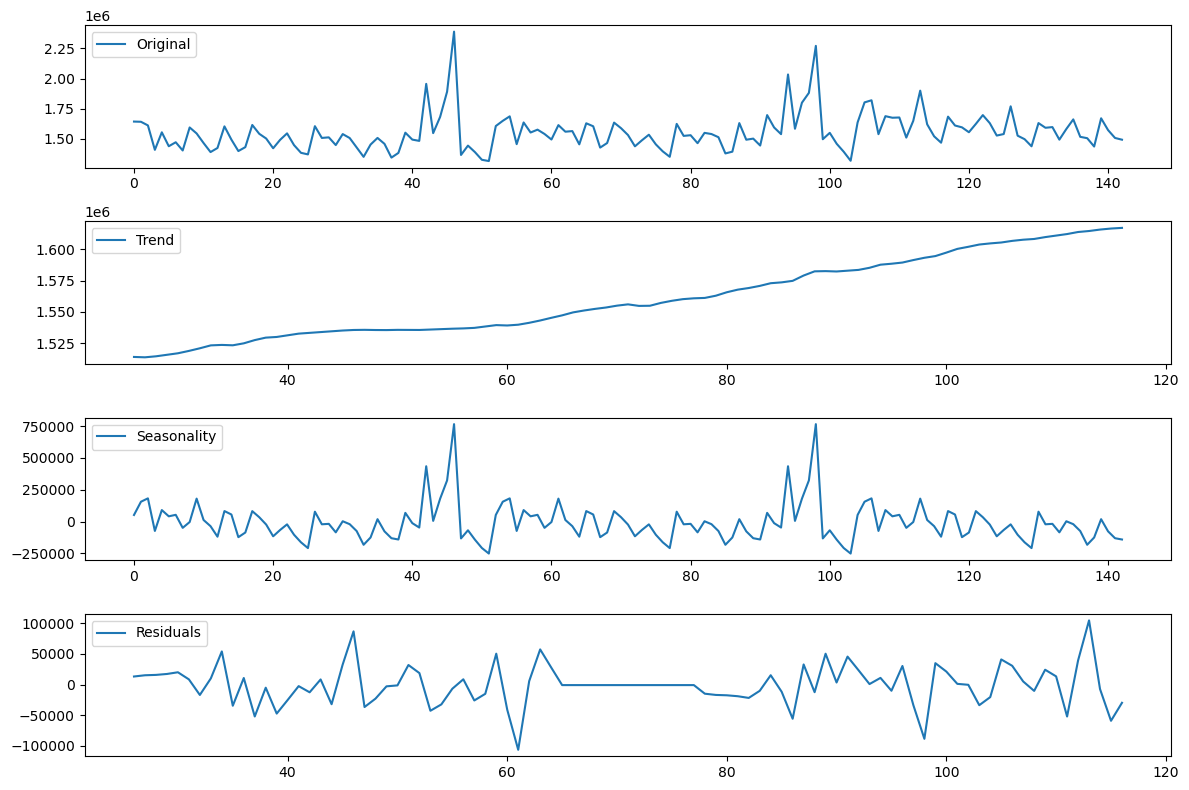

In [228]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series Decomposition
decomposition = seasonal_decompose(data['Weekly_Sales'], model='additive', period=52)  # weekly data

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data['Weekly_Sales'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


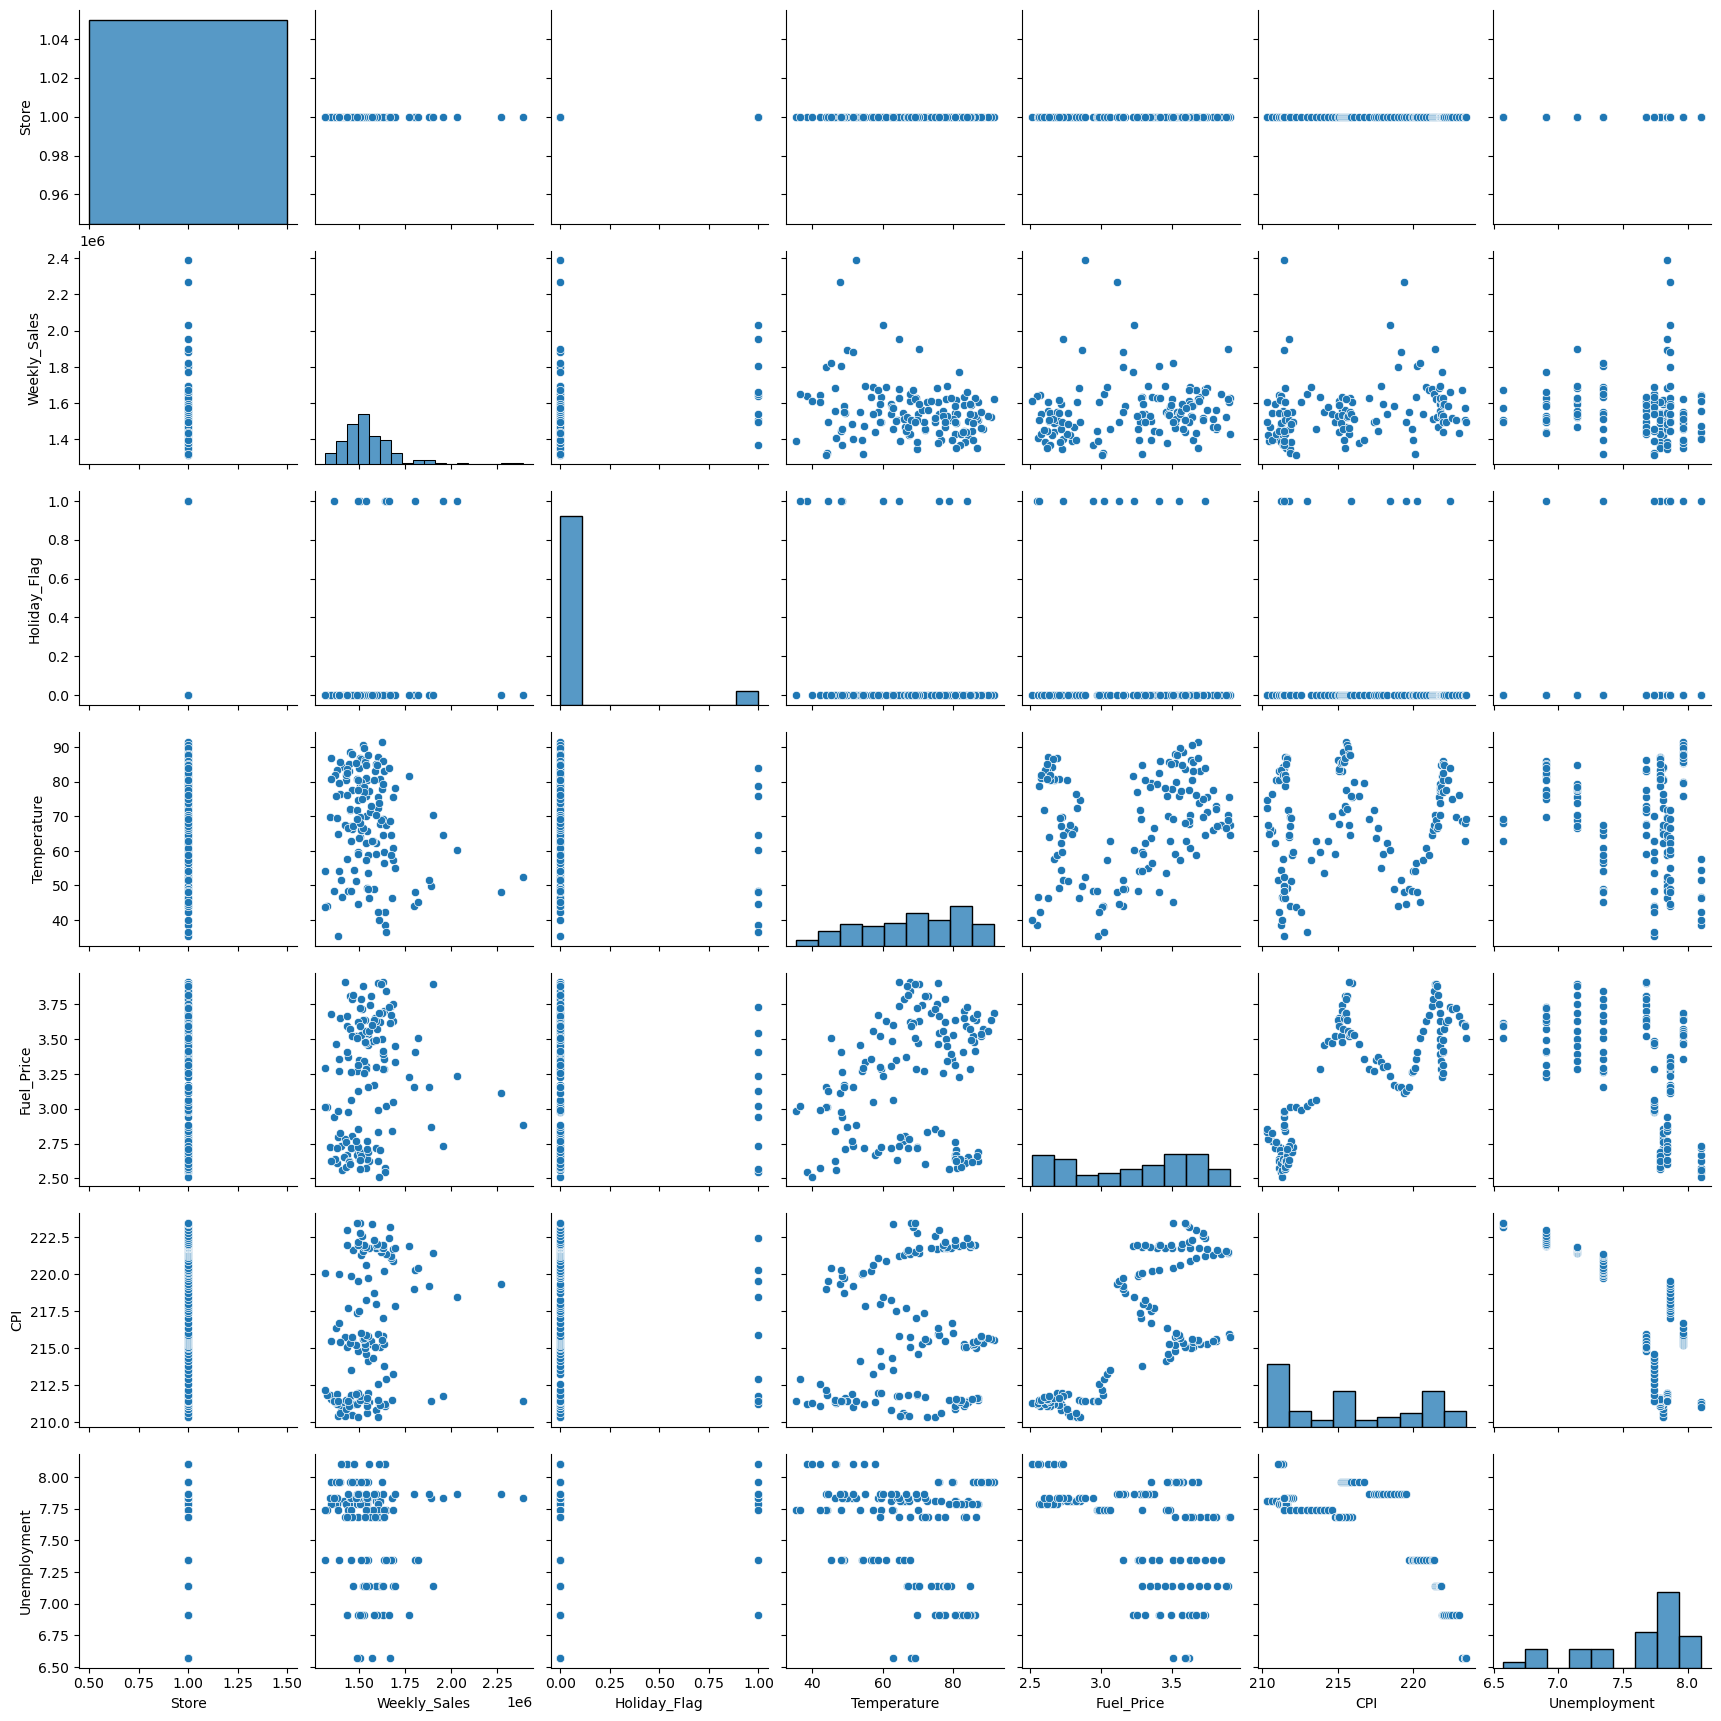

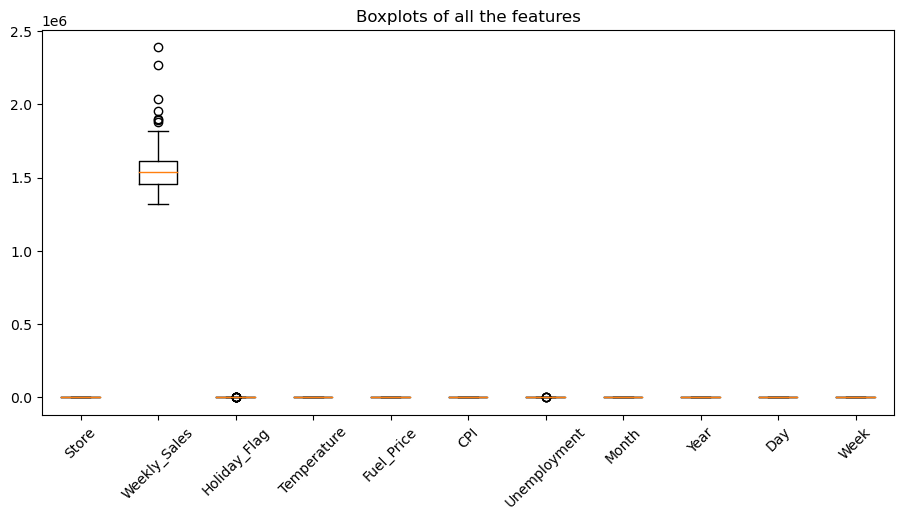

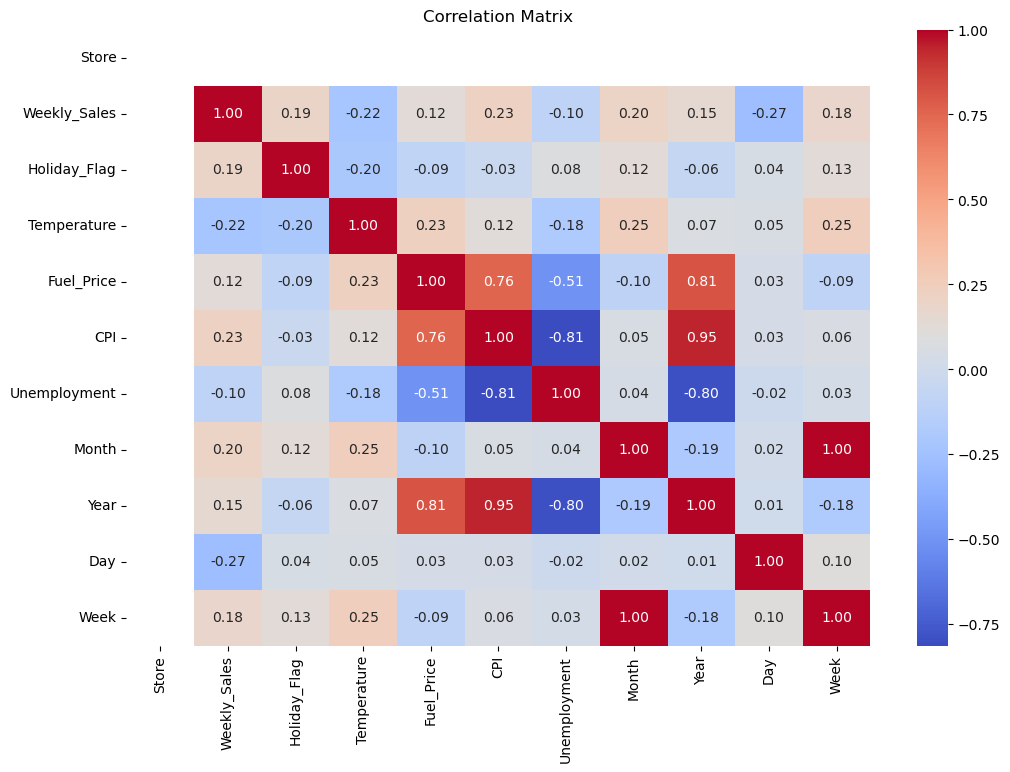

In [229]:
# Scatter plot of the above variables
sns.pairplot(data[['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment']]);
data.set_index('Date',inplace=True)
plt.figure(figsize=(11, 5))
plt.boxplot(data.values, labels=data.columns)
plt.title('Boxplots of all the features')
plt.xticks(rotation=45)
plt.show()

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Prediction Using Sklearn Regressor Model

In [230]:
from sklearn.ensemble import RandomForestRegressor

# Define the features and target
X = data.drop('Weekly_Sales', axis=1)
y = data['Weekly_Sales']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)


RandomForestRegressor(random_state=42)

In [231]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Example accuracy calculation (adjust as per regression context)
accuracy = 100 - mape  # Adjust as per your metric or context
print(f"Accuracy: {accuracy:.2f}%")

MAE: 20063.9658448278
RMSE: 31596.820699595984
Mean Absolute Percentage Error (MAPE): 1.18%
Accuracy: 98.82%


                Actual     Predicted       Error
Date                                            
2010-03-05  1554806.68  1.574609e+06 -19802.7038
2010-04-09  1545418.53  1.553756e+06  -8337.3162
2010-04-23  1391256.12  1.401518e+06 -10261.7235
2010-04-30  1425100.71  1.417502e+06   7598.4402
2010-06-11  1542561.09  1.544507e+06  -1945.8184


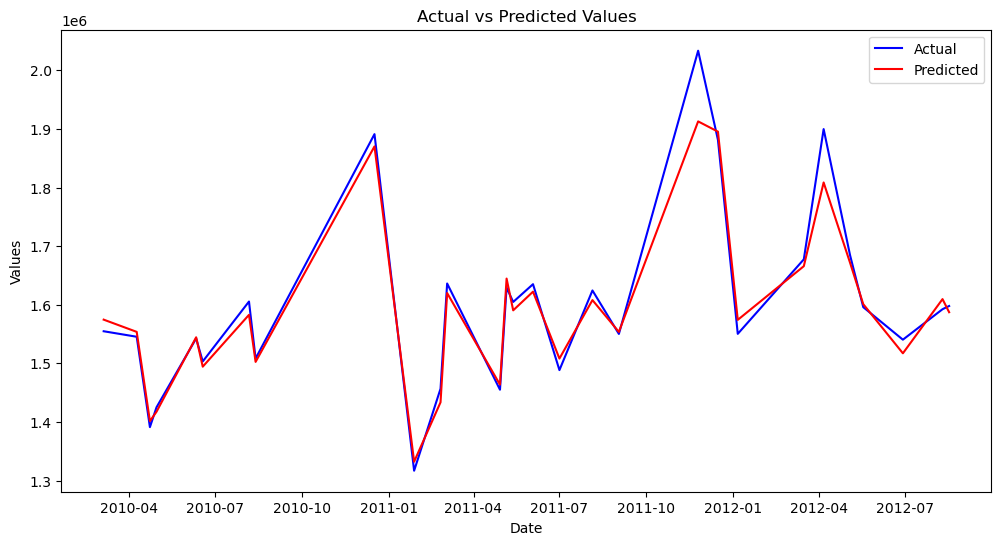

In [232]:
result=X_test
result['Date'] = pd.to_datetime(X_test[['Year', 'Month', 'Day']])

results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Error': y_test.values - y_pred
})

# Add the 'Date' column from X_test to results_df
results_df['Date'] = result['Date'].values

# Optionally, set 'Date' as the index if needed
results_df.set_index('Date', inplace=True)


results_df = results_df.sort_values(by='Date')
print(results_df.head())

plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual', color='b')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

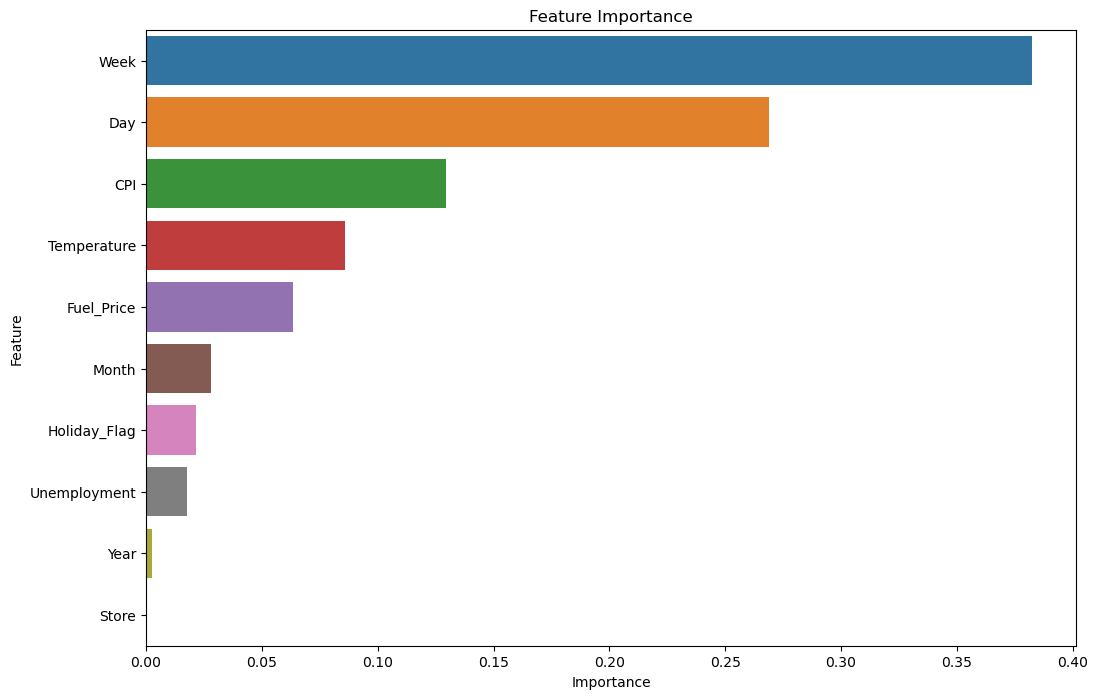

In [233]:
# Get feature importance
feature_importance = rf.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance')
plt.show()

# Prediction using Xgboost 

In [234]:
features=['Week','Day','CPI','Temperature','Fuel_Price','Month','Holiday_Flag','Unemployment','Year']
X = data[features]
y = data['Weekly_Sales']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [235]:
X.columns

Index(['Week', 'Day', 'CPI', 'Temperature', 'Fuel_Price', 'Month',
       'Holiday_Flag', 'Unemployment', 'Year'],
      dtype='object')

In [236]:
import xgboost as xgb
# Initialize the model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)

# Train the model
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=True)


[0]	validation_0-rmse:152208.04507	validation_1-rmse:164106.08314
[1]	validation_0-rmse:151139.80499	validation_1-rmse:162629.36768
[2]	validation_0-rmse:150085.34048	validation_1-rmse:161156.57367
[3]	validation_0-rmse:149036.73223	validation_1-rmse:159711.92968
[4]	validation_0-rmse:147997.86138	validation_1-rmse:158283.36148
[5]	validation_0-rmse:146972.42795	validation_1-rmse:156858.20149
[6]	validation_0-rmse:145949.42144	validation_1-rmse:155456.10800
[7]	validation_0-rmse:144942.81331	validation_1-rmse:154059.66408
[8]	validation_0-rmse:143938.46115	validation_1-rmse:152691.34022
[9]	validation_0-rmse:142946.54823	validation_1-rmse:151338.21369
[10]	validation_0-rmse:141960.65479	validation_1-rmse:150000.91261
[11]	validation_0-rmse:140990.70858	validation_1-rmse:148666.17820
[12]	validation_0-rmse:140022.77045	validation_1-rmse:147352.59981
[13]	validation_0-rmse:139070.52524	validation_1-rmse:146050.63828
[14]	validation_0-rmse:138123.15811	validation_1-rmse:144769.34452
[15]	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [237]:
y_pred = model.predict(X_test)


# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Example accuracy calculation (adjust as per regression context)
accuracy = 100 - mape  # Adjust as per your metric or context
print(f"Accuracy: {accuracy:.2f}%")

Root Mean Squared Error (RMSE): 70910.13813132425
Mean Absolute Percentage Error (MAPE): 2.95%
Accuracy: 97.05%


                Actual    Predicted      Error
Date                                          
2010-03-05  1554806.68  1546012.750   8793.930
2010-04-09  1545418.53  1580625.625 -35207.095
2010-04-23  1391256.12  1399686.625  -8430.505
2010-04-30  1425100.71  1398402.750  26697.960
2010-06-11  1542561.09  1529405.375  13155.715


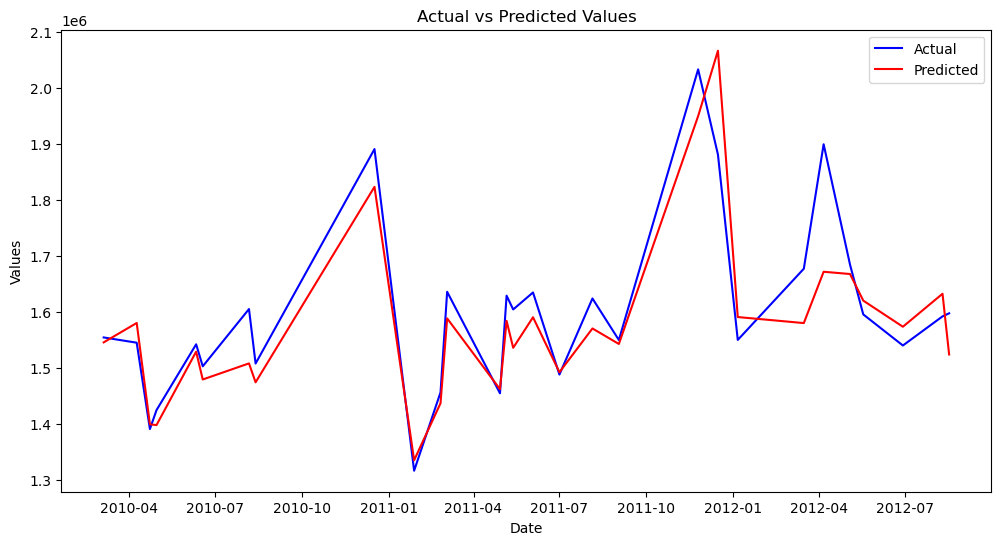

In [238]:

result=X_test
result['Date'] = pd.to_datetime(X_test[['Year', 'Month', 'Day']])

results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Error': y_test.values - y_pred
})

# Add the 'Date' column from X_test to results_df
results_df['Date'] = result['Date'].values

# Optionally, set 'Date' as the index if needed
results_df.set_index('Date', inplace=True)


results_df = results_df.sort_values(by='Date')
print(results_df.head())

plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual', color='b')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


        Feature  Importance
0          Week    0.373150
1           Day    0.228842
2           CPI    0.216084
7  Unemployment    0.086766
4    Fuel_Price    0.051283
3   Temperature    0.043324
6  Holiday_Flag    0.000551
5         Month    0.000000
8          Year    0.000000


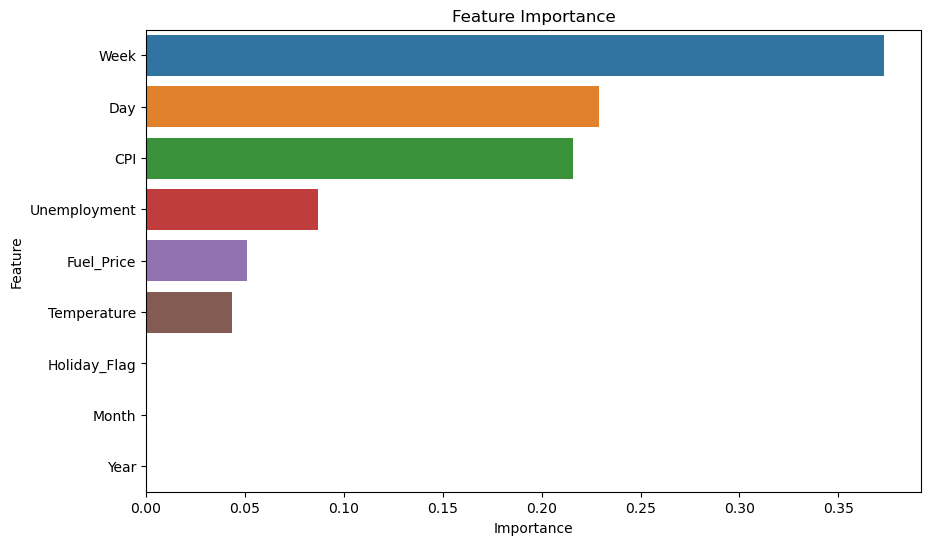

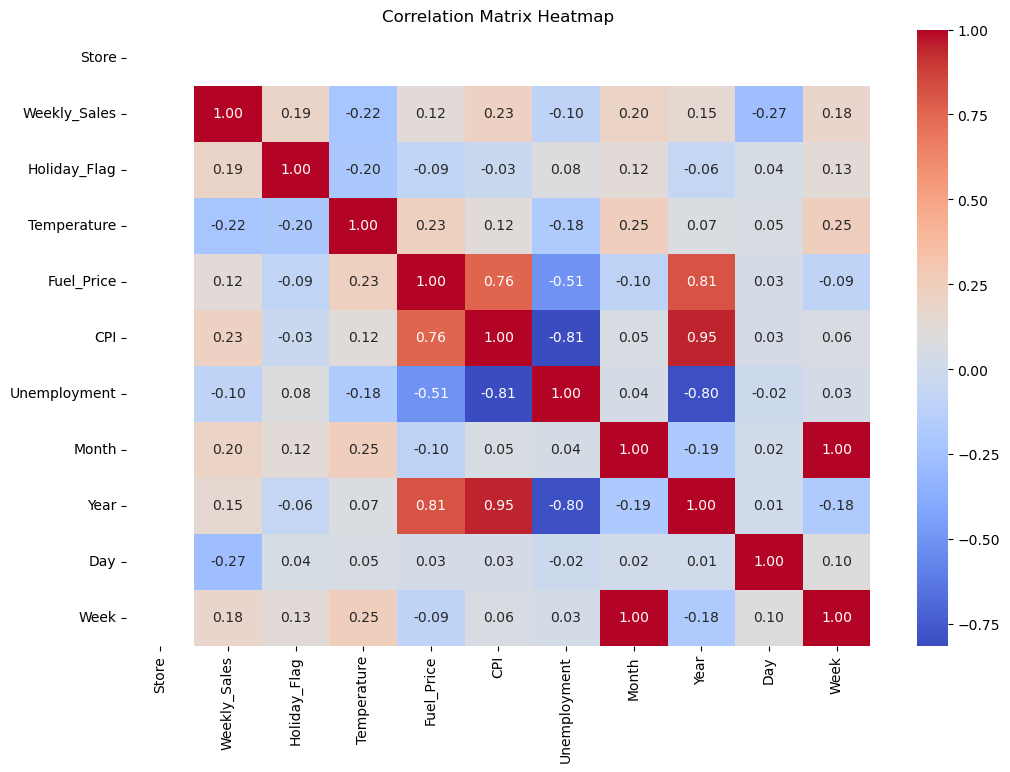

In [239]:
importance = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Outliers handling  (in case if accuracy can be increased)

In [240]:
data['lag_1'] = data['Weekly_Sales'].shift(1)
data['lag_7'] = data['Weekly_Sales'].shift(2)


data['rolling_mean_7'] = data['Weekly_Sales'].rolling(window=7).mean()
data['rolling_std_7'] = data['Weekly_Sales'].rolling(window=7).std()


data.fillna(0, inplace=True)


# Calculate Z-scores
data['z_score'] = np.abs((data['Weekly_Sales'] - data['Weekly_Sales'].mean()) / data['Weekly_Sales'].std())

# Set a threshold for Z-scores (e.g., 3)
outliers = data[data['z_score'] > 3]

Q1 = data['Weekly_Sales'].quantile(0.25)
Q3 = data['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Set a threshold for IQR (e.g., 1.5)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Weekly_Sales'] < lower_bound) | (data['Weekly_Sales'] > upper_bound)]

data_cleaned = data[(data['Weekly_Sales'] >= lower_bound) & (data['Weekly_Sales'] <= upper_bound)]



data['Weekly_Sales'] = np.where(data['Weekly_Sales'] > upper_bound, upper_bound, data['Weekly_Sales'])
data['Weekly_Sales'] = np.where(data['Weekly_Sales'] < lower_bound, lower_bound, data['Weekly_Sales'])

median_sales = data['Weekly_Sales'].median()

data['Weekly_Sales'] = np.where(data['Weekly_Sales'] > upper_bound, median_sales, data['Weekly_Sales'])
data['Weekly_Sales'] = np.where(data['Weekly_Sales'] < lower_bound, median_sales, data['Weekly_Sales'])

data['sales_smoothed'] = data['Weekly_Sales'].rolling(window=7, center=True).mean()
data['Weekly_Sales'].fillna(data['Weekly_Sales'], inplace=True)

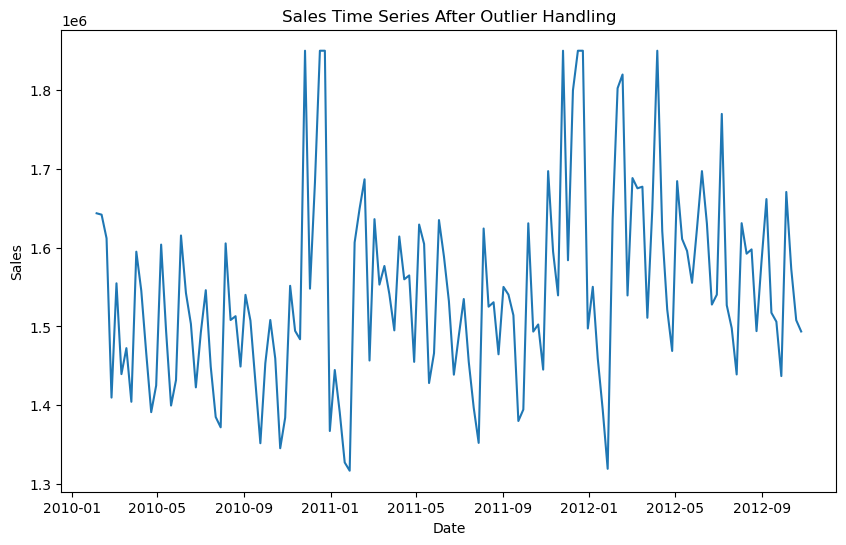

In [241]:
data=data.reset_index()
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Weekly_Sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Time Series After Outlier Handling')
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_10412\2950334121.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


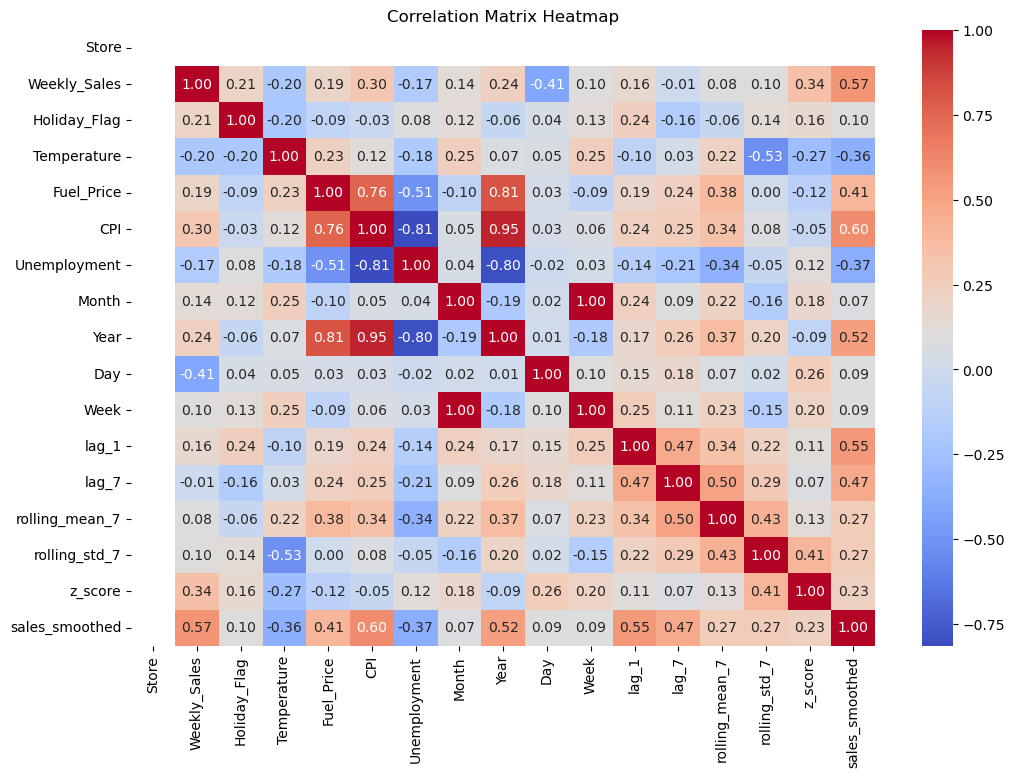

In [242]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Prediction using sklearn regressor after outlier handling

In [243]:
data.columns

Index(['Date', 'Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Year', 'Day', 'Week',
       'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'z_score',
       'sales_smoothed'],
      dtype='object')

In [244]:
#Encode categorical variables (if any)# In this dataset, the only categorical variable is 'Holiday_Flag' which is already encoded as 0 or 1

# scaler = StandardScaler()
# data[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']] = scaler.fit_transform(data[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])


In [245]:
from sklearn.ensemble import RandomForestRegressor

data.set_index('Date',inplace=True)

data = data.dropna()

# Define features and target
features = ['Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'Week', 
        'z_score','lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'sales_smoothed']
target = 'Weekly_Sales'

# Split the data
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Initialize and fit the Random Forest model
rf= RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [246]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Example accuracy calculation (adjust as per regression context)
accuracy = 100 - mape  # Adjust as per your metric or context
print(f"Accuracy: {accuracy:.2f}%")

MAE: 44575.113992857274
RMSE: 74064.31893050365
Mean Absolute Percentage Error (MAPE): 2.85%
Accuracy: 97.15%


                Actual     Predicted       Error
Date                                            
2010-02-26  1409727.59  1.435182e+06 -25454.1624
2010-03-26  1404429.92  1.403161e+06   1268.9174
2010-05-07  1603955.12  1.579019e+06  24936.5016
2010-05-14  1494251.50  1.534864e+06 -40612.3366
2010-05-21  1399662.07  1.398496e+06   1165.5916


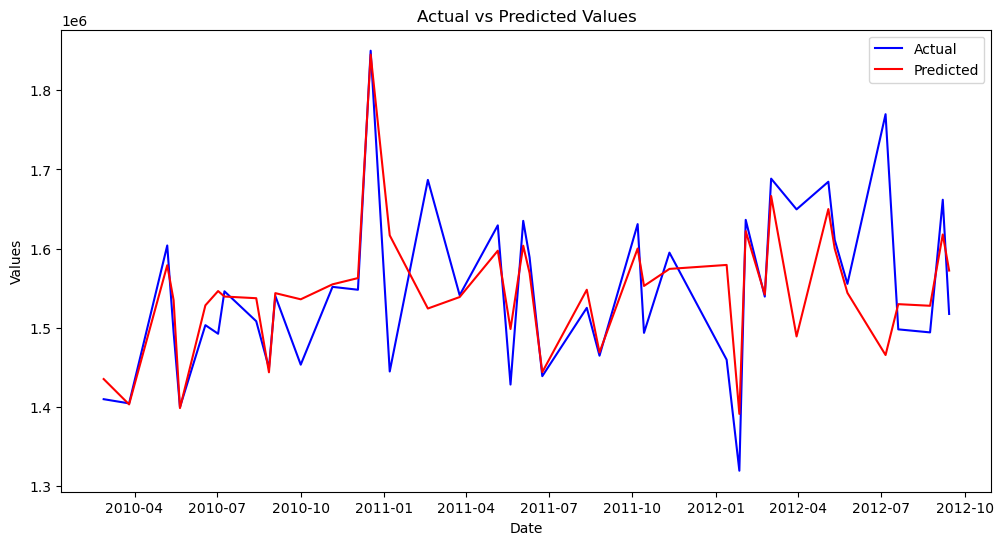

In [247]:
result=X_test
result['Date'] = pd.to_datetime(X_test[['Year', 'Month', 'Day']])

results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Error': y_test.values - y_pred
})

# Add the 'Date' column from X_test to results_df
results_df['Date'] = result['Date'].values

# Optionally, set 'Date' as the index if needed
results_df.set_index('Date', inplace=True)


results_df = results_df.sort_values(by='Date')
print(results_df.head())

plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual', color='b')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

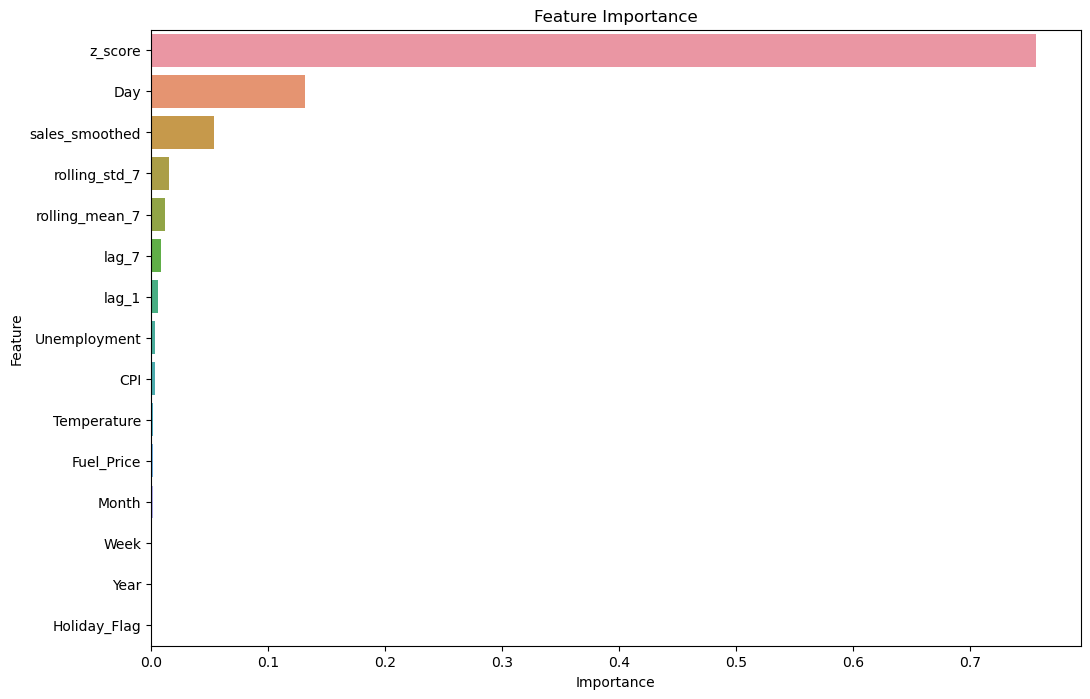

In [248]:
# Get feature importance
feature_importance = rf.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance')
plt.show()

In [249]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(best_model)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
RandomForestRegressor(max_depth=10, random_state=42)


# Prediction using Xgboost After Outlier Handling

In [250]:
data.columns
data_cleaned.columns

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'Month', 'Year', 'Day', 'Week', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_std_7', 'z_score'],
      dtype='object')

In [251]:
# Define features and target
features = ['Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'Week', 
       'z_score','lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'sales_smoothed']
target = 'Weekly_Sales'

# Split the data
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [252]:

import xgboost as xgb
# Initialize the model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)

# Train the model
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=True)


[0]	validation_0-rmse:126739.26156	validation_1-rmse:104677.89653
[1]	validation_0-rmse:125630.48977	validation_1-rmse:104150.13498
[2]	validation_0-rmse:124532.17013	validation_1-rmse:103632.36450
[3]	validation_0-rmse:123444.16317	validation_1-rmse:103137.52961
[4]	validation_0-rmse:122366.40496	validation_1-rmse:102652.42192
[5]	validation_0-rmse:121298.80395	validation_1-rmse:102163.78006
[6]	validation_0-rmse:120241.26655	validation_1-rmse:101697.70177
[7]	validation_0-rmse:119194.01520	validation_1-rmse:101238.22794
[8]	validation_0-rmse:118156.28535	validation_1-rmse:100790.82840
[9]	validation_0-rmse:117128.68393	validation_1-rmse:100336.76024
[10]	validation_0-rmse:116110.40218	validation_1-rmse:99907.51782
[11]	validation_0-rmse:115102.09857	validation_1-rmse:99483.07984
[12]	validation_0-rmse:114103.33074	validation_1-rmse:99069.29400
[13]	validation_0-rmse:113113.46047	validation_1-rmse:98665.18291
[14]	validation_0-rmse:112133.44373	validation_1-rmse:98268.84629
[15]	valid

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [253]:
y_pred = model.predict(X_test)


In [254]:

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Example accuracy calculation (adjust as per regression context)
accuracy = 100 - mape  # Adjust as per your metric or context
print(f"Accuracy: {accuracy:.2f}%")

Root Mean Squared Error (RMSE): 58064.947747487306
Mean Absolute Percentage Error (MAPE): 2.47%
Accuracy: 97.53%


                Actual    Predicted      Error
Date                                          
2010-03-12  1439541.59  1525156.125 -85614.535
2010-04-02  1594968.28  1528756.375  66211.905
2010-05-07  1603955.12  1583397.000  20558.120
2010-07-16  1448938.92  1452940.750  -4001.830
2010-08-06  1605491.78  1535518.000  69973.780


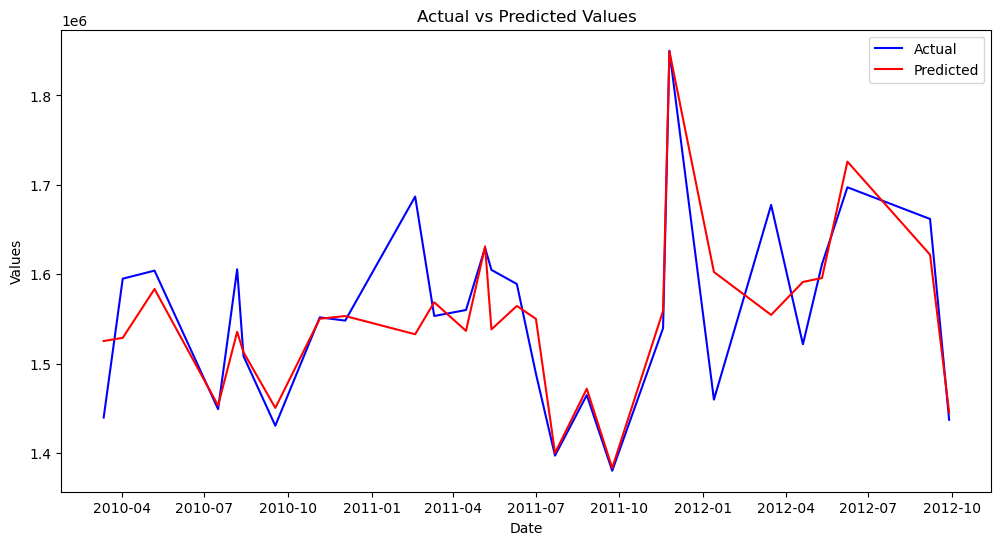

In [255]:
result=X_test
result['Date'] = pd.to_datetime(X_test[['Year', 'Month', 'Day']])

results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Error': y_test.values - y_pred
})

# Add the 'Date' column from X_test to results_df
results_df['Date'] = result['Date'].values

# Optionally, set 'Date' as the index if needed
results_df.set_index('Date', inplace=True)


results_df = results_df.sort_values(by='Date')
print(results_df.head())

plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual', color='b')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

           Feature  Importance
9          z_score    0.485904
7              Day    0.285841
14  sales_smoothed    0.107067
12  rolling_mean_7    0.036825
2       Fuel_Price    0.031908
13   rolling_std_7    0.024665
6            Month    0.008983
10           lag_1    0.007230
11           lag_7    0.003543
8             Week    0.003346
1      Temperature    0.002265
3              CPI    0.001198
0     Holiday_Flag    0.000967
4     Unemployment    0.000259
5             Year    0.000000


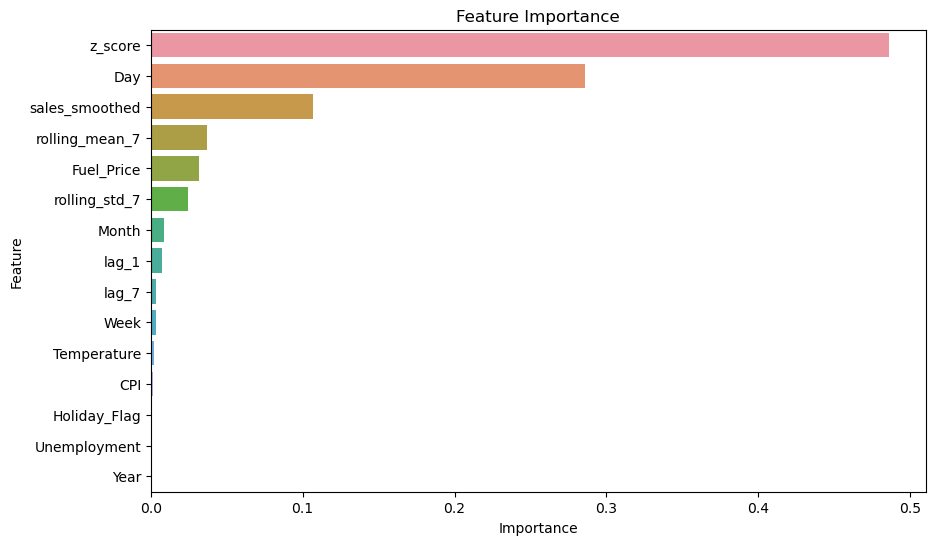

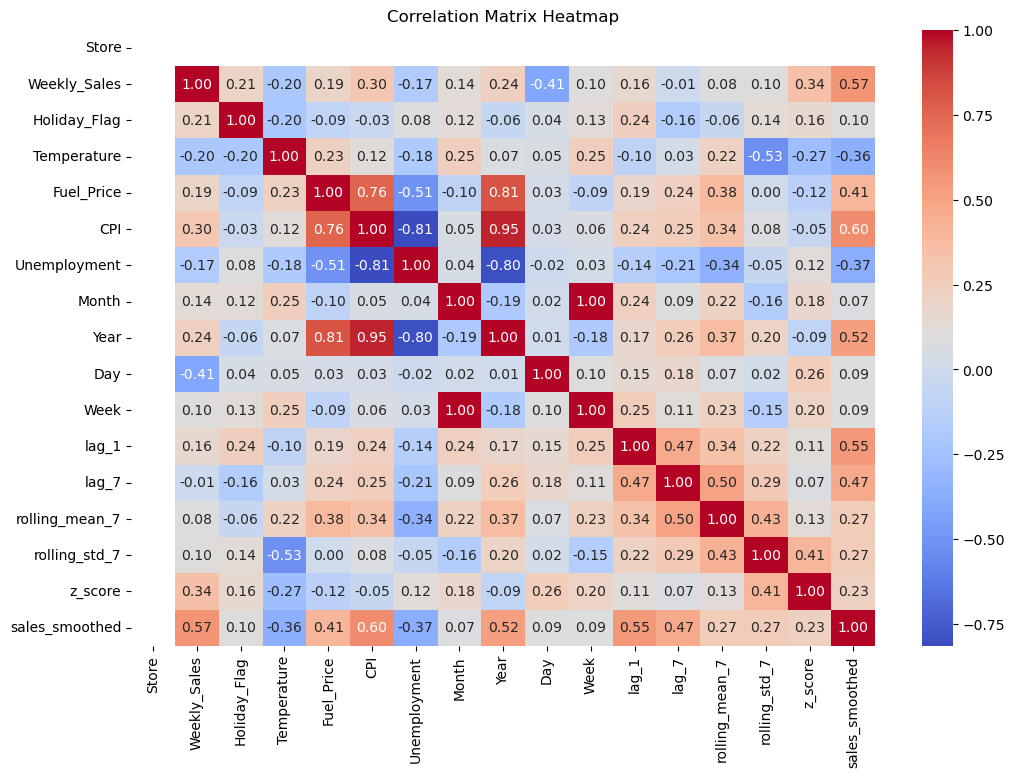

In [256]:
importance = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()